In this notebook, we experiment with a binary classification for full five sentence stories using our text classification model we developed in HW4

In [1]:
#imports
import pandas as pd
from collections import Counter, defaultdict
import torch
import torch.utils.data
import numpy as np
import string
from nltk import word_tokenize
from sklearn.metrics import accuracy_score

print("Cuda available:", torch.cuda.is_available())

Cuda available: True


In [2]:
#load the datasets
data_train_raw = pd.read_csv("ROCStories_winter2017.csv")
data_test_raw = pd.read_csv("cloze_test_2016.csv")
data_val_raw = pd.read_csv("cloze_val_2016.csv")


#test set 
#concat the context sentences together
test_context = [
    i + ' ' + j + ' ' + k + ' ' + l 
    for i, j, k, l in 
                zip(data_test_raw.InputSentence1.tolist() ,data_test_raw.InputSentence2.tolist(),
                    data_test_raw.InputSentence3.tolist(),data_test_raw.InputSentence4.tolist())
]

endings = data_test_raw.RandomFifthSentenceQuiz1.tolist(),data_test_raw.RandomFifthSentenceQuiz2.tolist()
answers =data_test_raw.AnswerRightEnding.tolist()
#seperate the endings for each example into appropriate lists
test_true = []
test_false = []
num_instances , num_columns = data_test_raw.shape
for i in range(num_instances):
    test_true.append(endings[answers[i]-1][i])
    test_false.append(endings[(answers[i]+2)%2][i])
    
#train set
train_context = [i + ' ' + j +' ' + k + ' ' + l for i, j, k, l in 
                 zip(data_train_raw.sentence1.tolist(),data_train_raw.sentence2.tolist(),
                     data_train_raw.sentence3.tolist(),data_train_raw.sentence4.tolist())]
train_end = data_train_raw.sentence5.tolist()

# validation set (duplicate code from above, probably couldve just made a function to process the test and
# val sets but oh well)
val_context = [i + ' ' + j +' ' + k + ' ' + l for i, j, k, l in 
                zip(data_val_raw.InputSentence1.tolist() ,data_val_raw.InputSentence2.tolist(),
                    data_val_raw.InputSentence3.tolist(),data_val_raw.InputSentence4.tolist())]
val_endings = data_val_raw.RandomFifthSentenceQuiz1.tolist(),data_val_raw.RandomFifthSentenceQuiz2.tolist()
val_answers =data_val_raw.AnswerRightEnding.tolist()
#seperate the endings for each example into appropriate lists
val_true = []
val_false = []
num_instances , num_columns = data_val_raw.shape
for i in range(num_instances):
    val_true.append(val_endings[val_answers[i]-1][i])
    val_false.append(val_endings[(val_answers[i]+2)%2][i])
    
#check the first 20 examples in the test and val set to see how it looks
print("**********TEST SET**********\n")
for i in range(20):
    print(test_context[i])
    print("TRUE ENDING:\t", test_true[i])
    print("FALSE ENDING:\t", test_false[i])
    print("\n")
    
print("**********VALIDATION SET**********\n")
for i in range(20):
    print(val_context[i])
    print("TRUE ENDING:\t", val_true[i])
    print("FALSE ENDING:\t", val_false[i])
    print("\n")

**********TEST SET**********

My friends all love to go to the club to dance. They think it's a lot of fun and always invite. I finally decided to tag along last Saturday. I danced terribly and broke a friend's toe.
TRUE ENDING:	 The next weekend, I was asked to please stay home.
FALSE ENDING:	 My friends decided to keep inviting me out as I am so much fun.


I tried going to the park the other day. The weather seemed nice enough for a walk. Within minutes of getting there I started sneezing. My eyes were watery and it was hard to breathe.
TRUE ENDING:	 My allergies were too bad and I had to go back home.
FALSE ENDING:	 It reminded me of how much I loved spring flowers.


Avery was married with children. She was tired of her boring life. One day, she decided to meet up with an old boyfriend from college. She made poor decisions that night and was unfaithful to her husband.
TRUE ENDING:	 Avery regretted what she did the next day.
FALSE ENDING:	 Avery thought her children would be happy 

Further playing can be done with the dataset, but we now have the base components needed to use for a simple model to get a proper evaluation framework set up. 

The train set only has the proper ending for stories, unlike the test and validation set, where there are 2 possible endings. If we want a train corpus that includes false stories endings as well as the true endings, we could assign random endings to half of the dataset. Each instance in the dataset should then have a label marking it as a coherent or incoherent story.

As a first approach, we could modify the dataset to turn this into a binary classification problem. We have a functional text classifier from HW4, it should be straightforward to implement with our dataset

In [3]:
#Vocabulary class courtesy of HW4

class MyVocabulary:
    def __init__(self, special_tokens=None):
        self.w2idx = {}
        self.idx2w = {}
        self.w2cnt = defaultdict(int)
        self.special_tokens = special_tokens
        if self.special_tokens is not None:
            self.add_tokens(special_tokens)

    def add_tokens(self, tokens):
        for token in tokens:
            self.add_token(token)
            self.w2cnt[token] += 1

    def add_token(self, token):
        if token not in self.w2idx:
            cur_len = len(self)
            self.w2idx[token] = cur_len
            self.idx2w[cur_len] = token

    def prune(self, min_cnt=2):
        to_remove = set([token for token in self.w2idx if self.w2cnt[token] < min_cnt])
        #print(set(self.special_tokens))
        
        #INSERTED THESE CHANGES MYSELF
        for token in self.special_tokens:
            if token in to_remove:
                to_remove.remove(token)
        #THE ORIGINAL CODE IN PRUNE WAS REMOVING <PAD> FROM THE VOCAB
        #to_remove ^= set(self.special_tokens)
        #print('<PAD>' in to_remove,self.w2cnt['<PAD>'])

        for token in to_remove:
            self.w2cnt.pop(token)

        self.w2idx = {token: idx for idx, token in enumerate(self.w2cnt.keys())}
        self.idx2w = {idx: token for token, idx in self.w2idx.items()}
        
        #print("Pad in w2cnt", '<PAD>' in self.w2cnt)
        #print("Pad in w2idx", '<PAD>' in self.w2idx)
        #print("Pad in idx2w", self.idx2w[0] is '<PAD>')
        #print(self.w2idx['<PAD>'])

    def __contains__(self, item):
        return item in self.w2idx

    def __getitem__(self, item):
        if isinstance(item, str):
            return self.w2idx[item]
        elif isinstance(item , int):
            return self.idx2w[item]
        else:
            raise TypeError("Supported indices are int and str")

    def __len__(self):
        return(len(self.w2idx))

In [4]:
#Text classification dataset from HW4

class TextClassificationDataset(torch.utils.data.Dataset):
    def __init__(self, texts, labels, vocab=None, labels_vocab=None, max_len=50, lowercase=True):
        """
        Args:
            texts (list of str): texts of the dataset examples
            labels (list of str): the correponding labels of the dataset examples
            vocab (MyVocabulary, optional): vocabular to convert text to indices. If not provided, will be created based on the texts
            labels_vocab (MyVocabulary, optional): vocabular to convert labels to indices. If not provided, will be created based on the labels
            max_len (int): maximum length of the text. Texts shorter than max_len will be cut at the end
            lowercase (bool, optional): a fag specifying whether or not the input text should be lowercased
        """
        
        self.max_len = max_len
        self.lowercase = lowercase
        

        self.texts = [self._preprocess(t, max_len=max_len, lowercase=lowercase) for t in texts]
        self.labels = labels

        if vocab is None:
            vocab = MyVocabulary(['<PAD>', '<UNK>'])
            for text in self.texts:
                vocab.add_tokens(text)
            
        if labels_vocab is None:
            labels_vocab = MyVocabulary()
            labels_vocab.add_tokens(labels)
            
        self.vocab = vocab
        self.labels_vocab = labels_vocab
        
    def _preprocess(self, text, max_len=None, lowercase=True):
        """
        Preprocess a give dataset example
        Args:
            text (str): given dataset example
            max_len (int, optional): maximum sequence length
            lowercase (bool, optional): a fag specifying whether or not the input text should be lowercased
        
        Returns:
            a list of tokens for a given text span
        """ 
        ### YOUR CODE BELOW ###
        if lowercase:
            text = text.lower()
        # tokenize the input text
       
        tokens = []
        tokens = word_tokenize(text)
        
        # cut the list of tokens to `max_len` if needed 
        if len(tokens) > max_len:
            del tokens[max_len:]
        tokens = self._pad(tokens)
        ### YOUR CODE ABOVE ###
        return tokens
    
    def _pad(self, tokens):
        """
        Pad tokens to self.max_len
        Args:
            tokens (list): a list of str tokens for a given example
            
        Returns:
            list: a padded list of str tokens for a given example
        """
        # pad the list of tokens to be exactly of the `max_len` size
        ### YOUR CODE BELOW ###
        if len(tokens) < self.max_len:
            for i in range(len(tokens), self.max_len):
                tokens.append("<PAD>") 
        ### YOUR CODE ABOVE ###
        return tokens

    def __getitem__(self, idx):
        """
        Given an index, return a formatted dataset example
        
        Args:
            idx (int): dataset index
            
        Returns:
            tuple: a tuple of token_ids based on the vocabulary mapping  and a corresponding label
        """
        ### YOUR CODE BELOW ###
        tokens = []
        words = self.texts[idx]
        for word in words:
            if word not in self.vocab.w2cnt:
                #print(word)
                tokens.append(self.vocab.w2idx['<UNK>'])
            elif word != '<PAD>':
                tokens.append(self.vocab.w2idx[word])
            elif word == '<PAD>':
                tokens.append(self.vocab.w2idx["<PAD>"])
                #print("found pad")
        label = self.labels[idx]
        ### YOUR CODE ABOVE ###
        
        return  np.asarray(tokens), np.asarray(self.labels_vocab.w2idx[label])

    def __len__(self):
        return len(self.texts)

Lets modify the datasets.
A train set should have the full five sentence story, as well as a label marking it as a coherent story (with the correct expected ending) or an incoherent story (false ending). 

The challenge from this approach is the structure of the original train set, as discussed above. We propose that taking half of the train examples, and shuffling the endings around randomly should suffice, but it also seems likely that this may not give the kind of dataset that would be ideal. Stories marked as incoherent will presumably have endings that are completely unrelated to the origianl story. This will contrast with the premade false endings in our test dataset, which will seem much more likely as possible coherent endings in comparison to the modified train set stories. Our prediction is that the accuracy will not be great.

In [5]:
#code taken from 
#https://stackoverflow.com/questions/9557182/python-shuffle-only-some-elements-of-a-list

class MutableSlice(object):
    def __init__(self, baselist, begin, end=None):
        self._base = baselist
        self._begin = begin
        self._end = len(baselist) if end is None else end

    def __len__(self):
        return self._end - self._begin

    def __getitem__(self, i):
        return self._base[self._begin + i]

    def __setitem__(self, i, val):
        self._base[i + self._begin] = val
        
mylist = [1,2,3,4,5,6]
slice = MutableSlice(mylist, 2)
import random
random.shuffle(slice)
print(mylist)

[1, 2, 3, 6, 4, 5]


In [6]:
#shuffle half of the train endings before appending them to the contexts
length = len(train_end)
start = int(length/2)
stop = length - start
end_slice = MutableSlice(train_end, start)

#the following for loops surrounding the shuffle are for veryfing proper shuffling of story ends
#for i in range(length - 21, length-1):
#    print(train_end[i])

random.shuffle(end_slice)

#print("\n***************************\n")

#for i in range(length - 21, length-1):
#    print(train_end[i])

labels_train = []
for i in range(start):
    labels_train.append('coherent')
for i in range(stop):
    labels_train.append('incoherent')

#append the endings to the context
data_train = [i + ' ' + j for i, j in zip(train_context, train_end)]

#will do a similair approach to test data. No need for random shuffling of endings to produce incoherent endings
labels_test = []
mid = int(len(test_context)/2)
for i in range(mid):
    labels_test.append('coherent')
for i in range(len(test_context) - mid):
    labels_test.append('incoherent')

labels_val = labels_test
data_val = [i + ' ' + j for i, j in zip(val_context, val_true[0:mid] + val_false[mid:])]
data_test = [i + ' ' + j for i, j in zip(test_context, test_true[0:mid] + test_false[mid:])]

#we now have all three sets of labeled data, lets shuffle the sets before training

val = list(zip(data_val, labels_val))
test = list(zip(data_test, labels_test))
train = list(zip(data_train, labels_train))

random.shuffle(train)
random.shuffle(test)
random.shuffle(val)

data_val, labels_val = zip(*val)
data_train, labels_train = zip(*train)
data_test, labels_test = zip(*test)

#sanity check, looking at some of the data
for i in range(20):
    print(data_val[i], '\n' + labels_val[i], '\n')

Yvonne had always been overweight. For New Year's she made a resolution to start exercising. She began jogging everyday. In two months she had lost 23 pounds. Yvonne felt defeated. 
incoherent 

Around 11am, the school's fire alarm went off. Rushing towards the door, the students stopped when gunshots rang out. Then the teacher instructed them to hide under their desks. Diving under their desks, the students were petrified. They waited until the incident was over. 
coherent 

I love to play baseball but I hate watching baseball. It's fun to play but honestly it's so boring to watch. My dad loves to watch it and I sometimes sit with him and watch. We talk about the old days when we used to play together outside. I wish he would pass away already. 
incoherent 

John and Ed had a bet on who could get the most candy on Halloween. They left John's house at the same time going in different directions. They had two hours to gather as much as they could. When they got back to the house they we

In [40]:
print(len(labels_train))
print(len(labels_test))
print(len(labels_val))

#use below to train on validation set
#dataset_train = TextClassificationDataset(data_val, labels_val)

#use below to train with original training set
dataset_train = TextClassificationDataset(data_train, labels_train)
dataset_val = TextClassificationDataset(data_val, labels_val, vocab = dataset_train.vocab, labels_vocab = dataset_train.labels_vocab )
dataset_test = TextClassificationDataset(data_test, labels_test, vocab = dataset_train.vocab, labels_vocab = dataset_train.labels_vocab)

52665
1871
1871


In [41]:
print(len(dataset_train.vocab.w2cnt), "words before pruning")
dataset_train.vocab.prune()
print(len(dataset_train.vocab.w2cnt),"words after pruning")

28152 words before pruning
19295 words after pruning


In [42]:
class TextClassificationModel(torch.nn.Module):
    def __init__(self, embedding_size, vocab_size, hidden_size, nb_classes):
        super().__init__()
        
        self.embedding_size = embedding_size
        self.hidden_size = hidden_size
        self.nb_classes = nb_classes

        ### YOUR CODE BELOW ###
        self.embeddings = torch.nn.Embedding(vocab_size, embedding_size)
        self.GRU = torch.nn.GRU(embedding_size, hidden_size, batch_first = True)
        self.projection = torch.nn.Linear(hidden_size, nb_classes)
        ### YOUR CODE ABOVE ###
        
        
    def forward(self, inputs):
        ### YOUR CODE BELOW ###
        embeds = self.embeddings(inputs)
        outputs, garbage = self.GRU(embeds)
        outputs = torch.max(outputs, dim = 1)[0]
        #print(outputs)
        logits = self.projection(outputs)
        ### YOUR CODE ABOVE ###        
        
        return logits

In [43]:
# DATALOADER #
dataloader_train = torch.utils.data.DataLoader(dataset_train, shuffle=True, batch_size=64)
dataloader_test = torch.utils.data.DataLoader(dataset_test, shuffle=False, batch_size=64)
dataloader_val = torch.utils.data.DataLoader(dataset_val, shuffle=False, batch_size=64)

# MODEL INITIALIZATION #
model = TextClassificationModel(64, len(dataset_train.vocab), 128, 2)#2 labels

if torch.cuda.is_available():
    model = model.cuda()
    
# OPTIMIZER #
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# LOSS-FUNCTION #
criterion = torch.nn.CrossEntropyLoss()

In [44]:
# TRAINING #
losses = [] 
losses_val = []
for epoch in range(10):
    epoch_losses = []
    epoch_validation_losses = []
   
    #training loop
    for i, batch in enumerate(dataloader_train):
        optimizer.zero_grad()
        
        x, y = batch
        if torch.cuda.is_available():
            x = x.cuda()
            y = y.cuda()
        
        #print(y)
        logits = model(x)
        loss = criterion(logits, y)
        
        epoch_losses.append(loss.item())
        
        loss.backward()
        optimizer.step()
        
    #validation loop 
    #comment out if using validation set for training
    for i, batch in enumerate(dataloader_val):
        
        x, y = batch
        if torch.cuda.is_available():
            x = x.cuda()
            y = y.cuda()
        
        logits = model(x)
        loss = criterion(logits, y)
        
        epoch_validation_losses.append(loss.item())
        

    epoch_loss = np.mean(epoch_losses)
    epoch_loss_val = np.mean(epoch_validation_losses)
    losses.append(epoch_loss)
    losses_val.append(epoch_loss_val)
    
    print('Epoch {}, loss {}, validation loss {}'.format(epoch, epoch_loss, epoch_loss_val))
    #print('Epoch {}, loss {}'.format(epoch, epoch_loss))

Epoch 0, loss 0.6314419301573011, validation loss 0.8122355222702027
Epoch 1, loss 0.5531454169590881, validation loss 0.7682199617226918
Epoch 2, loss 0.49524122139807897, validation loss 0.8924843609333039
Epoch 3, loss 0.433933237415907, validation loss 0.9157297213872274
Epoch 4, loss 0.3694946887390292, validation loss 1.0092486719290414
Epoch 5, loss 0.3086251159665941, validation loss 1.1492801189422608
Epoch 6, loss 0.24731039081135467, validation loss 1.1941030323505402
Epoch 7, loss 0.190470973991609, validation loss 1.4343245406945546
Epoch 8, loss 0.1400563809409611, validation loss 1.6270085195700328
Epoch 9, loss 0.09876731205120556, validation loss 1.6557630896568298


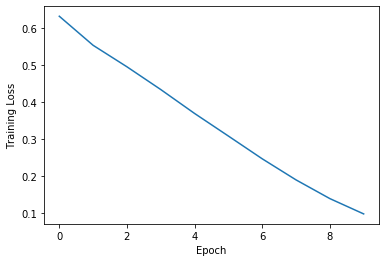

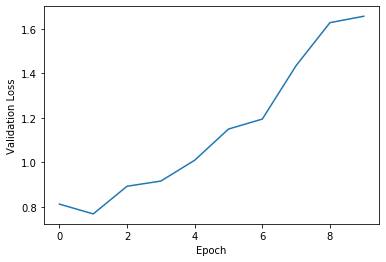

In [49]:
import matplotlib.pyplot as plt
plt.plot(losses)
plt.ylabel("Training Loss")
plt.xlabel("Epoch")
plt.show()

#validation loss
#comment out if using validation set for training
plt.plot(losses_val)
plt.ylabel("Validation Loss")
plt.xlabel("Epoch")
plt.show()


In [46]:
def predict(model, dataloader):
    """
    Predict probability distributions over classes on the test data
    
    Args:
        model: your torch.nn.Module() model object
        dataloader: test Dataloder() object
        
    Returns:
        tuple: np.array/list with true labels and np.array/list with predicted labels
    """
    y_pred = []
    y_true = []
    
    ### YOUR CODE BELOW ###
    for i, batch in enumerate(dataloader):
        x, y = batch
        
        if torch.cuda.is_available():
            x = x.cuda()
            
        outputs = model(x).detach().cpu()
        y_pred.append(torch.argmax(outputs.data, 1))
        y_true.append(y) 
    ### YOUR CODE ABOVE ###
    y_pred = np.concatenate(y_pred, axis=0)
    y_true = np.concatenate(y_true, axis=0)    
    
    return y_true, y_pred

In [47]:
y_true_train, y_pred_train = predict(model, dataloader_train)
y_true_test, y_pred_test = predict(model, dataloader_test)

In [48]:
### YOUR CODE BELOW ###
acc_train = accuracy_score(y_true_train, y_pred_train)
acc_test = accuracy_score(y_true_test, y_pred_test)
### YOUR CODE ABOVE ###

print('Accuracy train', acc_train)
print('Accuracy test', acc_test)

Accuracy train 0.9917212570018038
Accuracy test 0.48743987172634956
